In [1]:
from google.colab import drive
import os
import sys
from zipfile import ZipFile

# Mount Google Drive
drive.mount('/content/drive')

# Paths in Google Drive
INPUT_PATH = '/content/drive/MyDrive/moodmelody/kaggle-inputs'
WORKING_PATH = '/content/drive/MyDrive/moodmelody'

# Creating directories if they don't exist
os.makedirs(INPUT_PATH, exist_ok=True)
os.makedirs(WORKING_PATH, exist_ok=True)

# Create symlinks if they don't exist
try:
    os.symlink(INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

# Function to extract archives
def extract_archive(file_path, extract_path):
    if file_path.endswith('.zip'):
        with ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

# Extract all zip files in the input directory
for root, dirs, files in os.walk(INPUT_PATH):
    for file in files:
        if file.endswith('.zip'):
            file_path = os.path.join(root, file)
            extract_path = os.path.join(INPUT_PATH, os.path.splitext(file)[0])
            if not os.path.exists(extract_path):
                os.makedirs(extract_path)
            print(f"Extracting {file_path} to {extract_path}")
            extract_archive(file_path, extract_path)

print('Data source import complete.')


Mounted at /content/drive
Data source import complete.


In [2]:
!pip install spotipy
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00


In [3]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

sns.set(font_scale=1.3)
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download('wordnet')

import pickle
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
import spotipy
import numpy as np
import tensorflow as tf
import nltk
import streamlit
import sklearn
import pandas as pd
import psutil
import pkg_resources

spotipy_version = pkg_resources.get_distribution("spotipy").version

print(f"spotipy: {spotipy_version}")
print(f"numpy: {np.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"nltk: {nltk.__version__}")
print(f"streamlit: {streamlit.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"pandas: {pd.__version__}")
print(f"psutil: {psutil.__version__}")


spotipy: 2.25.1
numpy: 2.0.2
tensorflow: 2.19.0
nltk: 3.9.1
streamlit: 1.48.1
scikit-learn: 1.6.1
pandas: 2.2.2
psutil: 5.9.5


/tmp/ipython-input-3000941377.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [5]:
# loading datasets
df_train = pd.read_csv('/content/drive/MyDrive/moodmelody/kaggle-inputs/emotions-dataset-for-nlp/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/moodmelody/kaggle-inputs/emotions-dataset-for-nlp/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/moodmelody/kaggle-inputs/emotions-dataset-for-nlp/test.txt', names=['Text', 'Emotion'], sep=';')

In [6]:
!ls /content/drive/MyDrive/moodmelody/kaggle-inputs/


emotions-dataset-for-nlp


In [7]:
df_train.shape

(16000, 2)

In [8]:
df_test.shape

(2000, 2)

In [9]:
df_val.shape

(2000, 2)

In [10]:
df_train.Emotion.value_counts()

,count
Emotion,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [11]:
# % of emotions to check if balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] * 100

,count
Emotion,
joy,33.51250
sadness,29.16250
anger,13.49375
fear,12.10625
love,8.15000
surprise,3.57500


<Axes: xlabel='Emotion', ylabel='count'>

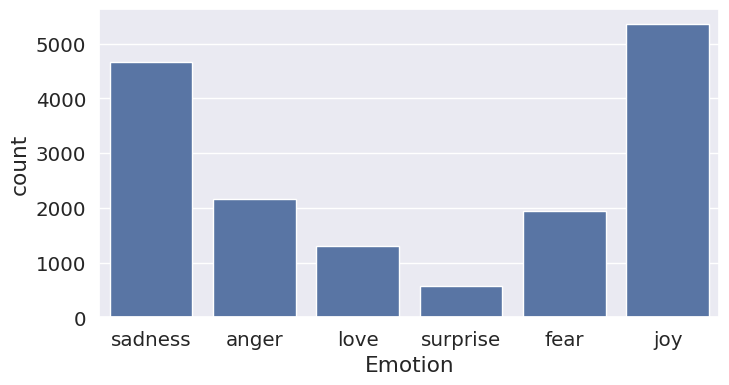

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train)

In [13]:
# checking for null values
df_train.isnull().sum()

,0
Text,0
Emotion,0


In [14]:
# duplicates
df_train.duplicated().sum()

np.int64(1)

In [15]:
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [16]:
# checking for text duplicates, that is, same text assigned to different emotions
df_train_duplicates = df_train[df_train.Text.duplicated() == True]
df_train_duplicates

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [17]:
# removing duplicated text
index = df_train_duplicates.index
df_train.drop(index, axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [18]:
df_test.isnull().sum()

,0
Text,0
Emotion,0


In [19]:
df_test.duplicated().sum()

np.int64(0)

In [20]:
df_test[df_test.Text.duplicated() == True]

,Text,Emotion


In [21]:
df_val.isnull().sum()

,0
Text,0
Emotion,0


In [22]:
df_val.duplicated().sum()

np.int64(0)

In [23]:
df_val[df_val.Text.duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [24]:
index = df_val[df_val.Text.duplicated() == True].index
df_val.drop(index, axis=0, inplace=True)
df_val.reset_index(inplace=True, drop=True)

In [25]:
# comparing rows of dataframes to check for data leakage
def dataframe_difference(df1, df2, which=None):
    """Finding rows which are different between two DataFrames."""

    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )

    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]

    # Returning the filtered DataFrame
    return diff_df

In [26]:
dataframe_difference(df_train, df_test, which='both')
dataframe_difference(df_train, df_val, which='both')
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge


In [27]:
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

In [28]:
# preprocessing
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word, pos='v') for word in text]
    return " ".join(text)

def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_numbers(text):
    return ''.join([char for char in text if not char.isdigit()])

def lower_case(text):
    return text.lower()

def remove_punctuations(text):
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    return text

def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def normalize_text(df):
    df['Text'] = df['Text'].apply(lower_case)
    df['Text'] = df['Text'].apply(remove_stop_words)
    df['Text'] = df['Text'].apply(remove_numbers)
    df['Text'] = df['Text'].apply(remove_punctuations)
    df['Text'] = df['Text'].apply(remove_urls)
    df['Text'] = df['Text'].apply(lemmatization)
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= remove_numbers(sentence)
    sentence= remove_punctuations(sentence)
    sentence= remove_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence


<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1147159277.py:20: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text).strip()


In [29]:
# creating this class just for the sake of pickling
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = lemmatizer
        self.stop_words = stop_words

    def lemmatization(self, text):
        text = text.split()
        text = [self.lemmatizer.lemmatize(word,pos='v') for word in text]
        return " ".join(text)

    def remove_stop_words(self, text):
        return " ".join([word for word in text.split() if word not in self.stop_words])

    def remove_numbers(self, text):
        return ''.join([char for char in text if not char.isdigit()])

    def lower_case(self, text):
        return text.lower()

    def remove_punctuations(self, text):
        text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
        text = re.sub('\s+', ' ', text).strip()
        return text

    def remove_urls(self, text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def normalized_sentence(self, sentence):
        sentence = self.lower_case(sentence)
        sentence = self.remove_stop_words(sentence)
        sentence = self.remove_numbers(sentence)
        sentence = self.remove_punctuations(sentence)
        sentence = self.remove_urls(sentence)
        sentence = self.lemmatization(sentence)
        return sentence

preprocessor = TextPreprocessor()

with open('/content/drive/MyDrive/moodmelody/text_preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)



<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3129119722.py:23: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text).strip()


In [30]:
df_train = normalize_text(df_train)
df_test = normalize_text(df_test)
df_val = normalize_text(df_val)

In [32]:
X_train = df_train['Text']
y_train = df_train['Emotion']
X_test = df_test['Text']
y_test = df_test['Emotion']
X_val = df_val['Text']
y_val = df_val['Emotion']

In [33]:
# encoding labels - emotions to encodings
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [34]:
print(set(y_train))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}


In [35]:
# converting these labels to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [36]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [37]:
emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
le.classes_ = np.array(emotions)
le.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='<U8')

In [38]:
# tokenizing
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test,X_val], axis=0))
vocab_size = len(tokenizer.word_index) + 1

In [39]:
vocab_size

13710

In [40]:
# Convert text to sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [41]:
# Padding sequences to maxlen
maxlen = max([len(seq) for seq in sequences_train])
X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

In [42]:
# before padding
sequences_train[0]

[57, 2, 514]

In [43]:
# after padding
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  57,   2, 514], dtype=int32)

In [44]:
# pickling the tokenizer, label encoder and maxlen for future use
with open('/content/drive/MyDrive/moodmelody/tokenizer.pkl', 'wb') as file:
  pickle.dump(tokenizer, file)

with open('/content/drive/MyDrive/moodmelody/label_encoder.pkl', 'wb') as file:
  pickle.dump(le, file)

with open('/content/drive/MyDrive/moodmelody/maxlen.pkl', 'wb') as file:
  pickle.dump(maxlen, file)

In [50]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d /content/glove


--2025-08-20 06:02:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-20 06:02:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-20 06:02:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [51]:
!cp /content/glove/glove.6B.200d.txt /content/drive/MyDrive/moodmelody/kaggle-inputs/


In [54]:
# Loading GloVe embeddings
path_to_glove_file = '/content/drive/MyDrive/moodmelody/kaggle-inputs/glove.6B.200d.txt'
embeddings_index = {}

In [55]:
# reading word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, *vector = line.split()
        embeddings_index[word] = np.array(vector, dtype=np.float32)

In [56]:
len(embeddings_index)

400000

In [57]:
# Creating embedding matrix(assigning word vectors to our vocab)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
hits, misses = 0, 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Converted {hits} words ({misses} misses)")


Converted 12480 words (1229 misses)


In [58]:
print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (13710, 200)


In [59]:
from tensorflow.keras.layers import BatchNormalization, Dropout
# defining and compiling
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 35, 200)        │     2,742,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 35, 128)        │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,985,142 (11.39 MB)

 Trainable params: 243,142 (949.77 KB)

 Non-trainable params: 2,742,000 (10.46 MB)

In [60]:
# Training model with early stopping
from keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, callbacks=[early_stopping])

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 183ms/step - accuracy: 0.3955 - loss: 1.5307 - val_accuracy: 0.5801 - val_loss: 1.1601
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.5947 - loss: 1.0972 - val_accuracy: 0.6722 - val_loss: 0.9316
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 165ms/step - accuracy: 0.7089 - loss: 0.8220 - val_accuracy: 0.7232 - val_loss: 0.7588
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 182ms/step - accuracy: 0.7785 - loss: 0.6317 - val_accuracy: 0.7823 - val_loss: 0.6158
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - accuracy: 0.8102 - loss: 0.5154 - val_accuracy: 0.8043 - val_loss: 0.5495
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 177ms/step - accuracy: 0.8530 - loss: 0.4091 - val_accuracy: 0.8288 - val_loss: 0.4967
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.8729 - loss: 0.3606 - val_accuracy: 0.8428 - val_loss: 0.4407
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.8868 - loss: 0

In [61]:
# Evaluating model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8558 - loss: 0.4405
Test Loss: 0.4411
Test Accuracy: 85.75%


In [62]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


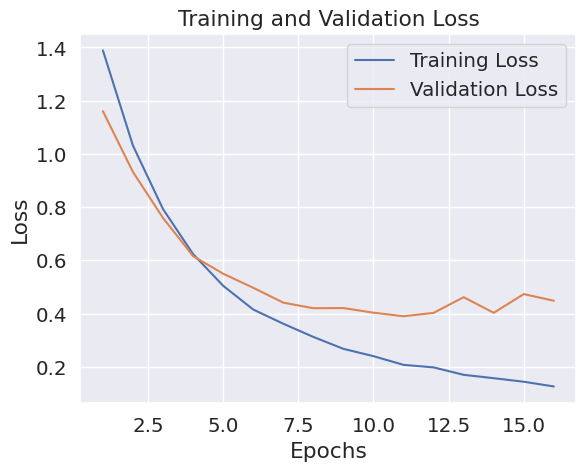

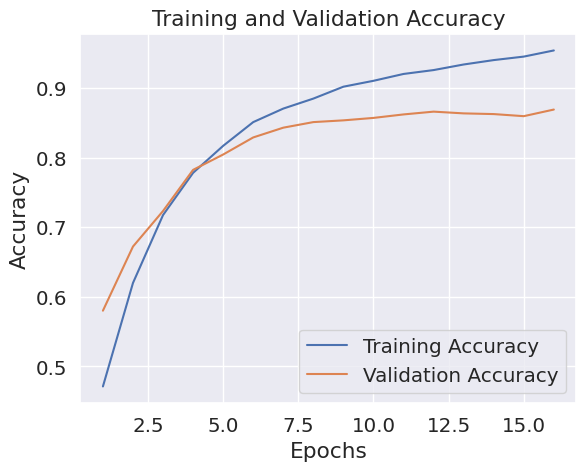

In [63]:
# visualising loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       275
           1       0.78      0.88      0.83       224
           2       0.90      0.88      0.89       695
           3       0.70      0.75      0.73       159
           4       0.90      0.90      0.90       581
           5       0.68      0.64      0.66        66

    accuracy                           0.86      2000
   macro avg       0.80      0.81      0.81      2000
weighted avg       0.86      0.86      0.86      2000



In [65]:
# some examples
sentences = [
           "He's over the moon about being accepted to the university",
           "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
           "I can't do it, I'm not ready to lose anything, just leave me alone",
           "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!",
          "I can't believe they did that to me; it's so frustrating and unfair!",
          "Walking alone at night in that neighborhood gives me chills and makes me anxious.",
          "Winning the competition filled me with immense happiness and excitement.",
          "Every time I see you, my heart fills with warmth and affection.",
           "The news of his departure brought tears to my eyes and a deep sense of sorrow.",
           "I was completely taken aback when they threw me a surprise birthday party!"


            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=maxlen, truncating='pre')

    predictions = model.predict(sentence)
    predicted_label = np.argmax(predictions, axis=-1)[0]
    print(f"Predicted Label: {predicted_label}")  # Debug print to check the predicted label
    predicted_emotion = le.inverse_transform([predicted_label])[0]  # Convert label back to emotion

    proba =  np.max(predictions)
    print(f"{predicted_emotion} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Label: 2
joy : 0.3770328760147095


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Label: 0
anger : 0.4049026668071747


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Label: 0
anger : 0.2687603533267975


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Label: 2
joy : 0.5086848139762878


I can't believe they did that to me; it's so frustrating and unfair!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Label: 0
anger : 0.540908932685852


Walking alone at night in that neighborhood gives me chills and makes me anxious.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label: 1
fear : 0.7900446057319641


Winning the competition filled me with immense happiness 

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
[[220  14  13   3  25   0]
 [  7 196   1   2   9   9]
 [ 11   8 612  41  16   7]
 [  3   1  30 120   5   0]
 [ 12  18  16   6 525   4]
 [  1  13   7   0   3  42]]


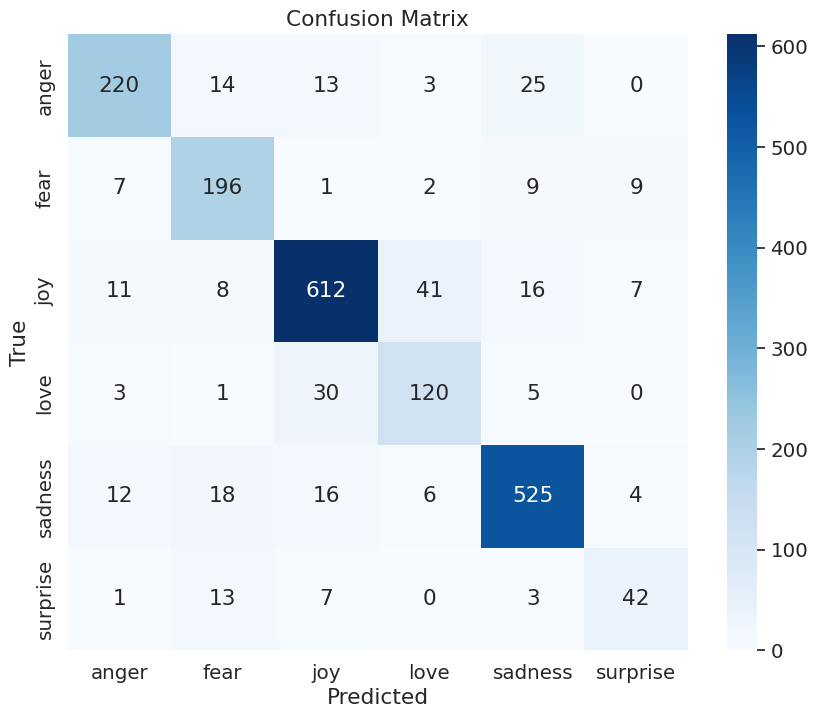

In [66]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test)
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_class)
print(cm)

emotion_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [67]:
model.save('/content/drive/MyDrive/moodmelody/Emotion Recognition from text 3.h5')

In [68]:
!pip install spotipy

In [69]:
pip install streamlit

In [70]:
# app.py
%%writefile app.py

import streamlit as st
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import logging

logging.basicConfig(level=logging.DEBUG)

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Replace with your Spotify app credentials
CLIENT_ID = 'dc88dca2f2e549bbbdef653f12ddb042'
CLIENT_SECRET = '00e8ea8136994ceaada7b3833c88edcf'
REDIRECT_URI = 'http://localhost:5000/callback'

# Authentication
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope="user-modify-playback-state user-read-playback-state",
                                               open_browser=False))

sp_oauth = SpotifyOAuth(client_id=CLIENT_ID,
                        client_secret=CLIENT_SECRET,
                        redirect_uri=REDIRECT_URI,
                        scope="user-modify-playback-state user-read-playback-state",
                        cache_path="./.spotifycache")

# Define song URIs for each emotion
emotion_to_song_uri = {
    'anger': 'spotify:track:7iN1s7xHE4ifF5povM6A48',    # let it be
    'fear': 'spotify:track:3KkXRkHbMCARz0aVfEt68P',     # sunflower
    'joy': 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',      # shape of you
    'love': 'spotify:track:3d9DChrdc6BOeFsbrZ3Is0',     # under the bridge
    'sadness': 'spotify:track:008McaJl3WM1UqxxVie9BP',  # the wisp sings
    'surprise': 'spotify:track:10nyNJ6zNy2YVYLrcwLccB'  # no surprises
}

# Load the saved model, tokenizer, label encoder, and maxlen
model_path = '/content/drive/MyDrive/moodmelody/Emotion Recognition from text 3.h5'
tokenizer_path = '/content/drive/MyDrive/moodmelody/tokenizer.pkl'
label_encoder_path = '/content/drive/MyDrive/moodmelody/label_encoder.pkl'
maxlen_path = '/content/drive/MyDrive/moodmelody/maxlen.pkl'

try:
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, 'rb') as file:
        tokenizer = pickle.load(file)
    with open(label_encoder_path, 'rb') as file:
        le = pickle.load(file)
    with open(maxlen_path, 'rb') as file:
        maxlen = pickle.load(file)
    st.success('Model and tokenizer loaded successfully!')
except OSError as e:
    st.error(f'Error loading model: {e}')

# Preprocessing steps
def lemmatization(text):
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

def remove_stop_words(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_numbers(text):
    return ''.join([char for char in text if not char.isdigit()])

def lower_case(text):
    return text.lower()

def remove_punctuations(text):
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    return text

def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def normalized_sentence(sentence):
    sentence = lower_case(sentence)
    sentence = remove_stop_words(sentence)
    sentence = remove_numbers(sentence)
    sentence = remove_punctuations(sentence)
    sentence = remove_urls(sentence)
    sentence = lemmatization(sentence)
    return sentence

# Function to preprocess and predict emotion
def predict_emotion(text):
    try:
        # Preprocessing
        text = normalized_sentence(text)
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, maxlen=maxlen, truncating='pre')

        # Predict emotion
        prediction = model.predict(padded_sequence)
        predicted_label = np.argmax(prediction, axis=1)
        predicted_emotion = le.inverse_transform(predicted_label)[0]

        return predicted_emotion

    except Exception as e:
        st.error(f"An error occurred during prediction: {e}")
        return None

# Function to play song based on emotion
def play_song(emotion):
    song_uri = emotion_to_song_uri.get(emotion)
    if song_uri:
        try:
            devices = sp.devices()
            if devices['devices']:
                device_id = devices['devices'][0]['id']
                sp.start_playback(device_id=device_id, uris=[song_uri])
                st.write(f"Playing song for {emotion}: {song_uri}")
            else:
                st.write("No active devices found.")

        except spotipy.SpotifyException as e:
            st.error(f"An error occurred while playing song: {e}")
    else:
        st.write("No song found for this emotion.")

def main():
    st.title("MoodMelody: Emotion-based Music Recommender")

    text = st.text_input("Enter how you are feeling:")
    if st.button("Detect Emotion and Play Song"):
        detected_emotion = predict_emotion(text)
        if detected_emotion:
            st.write(f"Detected emotion: {detected_emotion}")

            # Display the authentication URL if token is not cached
            token_info = sp_oauth.get_cached_token()
            if not token_info:
                auth_url = sp_oauth.get_authorize_url()
                st.markdown(f"[Authenticate with Spotify]({auth_url})")
                code = st.text_input("Enter the code from the URL after authentication:")
                if code:
                    try:
                        token_info = sp_oauth.get_access_token(code)
                        global sp
                        sp = spotipy.Spotify(auth=token_info['access_token'])
                        play_song(detected_emotion)
                    except spotipy.SpotifyOauthError as e:
                        st.error(f"Spotify OAuth error: {e}")
            else:
                sp = spotipy.Spotify(auth=token_info['access_token'])
                play_song(detected_emotion)

if __name__ == "__main__":
    main()

Writing app.py


In [71]:
!curl icanhazip.com

35.230.176.190


In [72]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.230.176.190:8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋your url is: https://smooth-clocks-fly.loca.lt
yes
no
  Stopping...
^C


ERROR: Could not install packages due to an OSError: Invalid URL '2.0.2': No scheme supplied. Perhaps you meant https://2.0.2?

